In [61]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [62]:
df = pd.read_csv(str(Path(os.getcwd()).parent.parent / 'data' / 'all_job_post.csv'))

In [63]:
df

,job_id,category,job_title,job_description,job_skill_set
0,3902668440,HR,Sr Human Resource Generalist,SUMMARY\nTHE SR. HR GENERALIST PROVIDES HR EXP...,"['employee relations', 'talent acquisition', '..."
1,3905823748,HR,Human Resources Manager,BE PART OF A STELLAR TEAM AT YSB AS THE MANAGE...,"['Talent Acquisition', 'Employee Performance M..."
2,3905854799,HR,Director of Human Resources,OUR CLIENT IS A THRIVING ORGANIZATION OFFERING...,"['Human Resources Management', 'Recruitment', ..."
3,3905834061,HR,Chief Human Resources Officer,JOB TITLE: CHIEF HUMAN RESOURCES OFFICER (CHRO...,"['talent management', 'organizational developm..."
4,3906250451,HR,Human Resources Generalist (Hybrid Role),DESCRIPTION\n\n WHO WE ARE \n\nAVI-SPL IS A DI...,"['Microsoft Office', 'Data analysis', 'Employe..."
...,...,...,...,...,...
1162,3905299905,BUSINESS-DEVELOPMENT,Intern - Business Development,REQUIREMENTS\n\n DESCRIPTION & REQUIREMENTS \n...,"['MS Office Suite', 'PowerPoint', 'Excel', 're..."
1163,3885829894,BUSINESS-DEVELOPMENT,Business Development Representative,IT'S FUN TO WORK IN A COMPANY WHERE PEOPLE TRU...,"['Collaboration', 'Communication', 'Problem So..."
1164,3901649881,BUSINESS-DEVELOPMENT,Enterprise Business Development Representative...,JOIN OUR DYNAMIC AI TEAM AS AN ENTERPRISE BUSI...,"['Salesforce', 'data analysis', 'lead generati..."
1165,3904049863,BUSINESS-DEVELOPMENT,Senior Director Business Development,ROOM 8 GROUP IS THE WORLD’S FASTEST GROWING ST...,"['business development', 'sales', 'corporate s..."


In [64]:
df[df['category'] == 'HR']['job_title'].value_counts()

job_title
Human Resources Generalist                                               34
Human Resources Manager                                                  28
Human Resources Business Partner                                         15
Human Resources Coordinator                                              11
Human Resources Specialist                                                9
                                                                         ..
Vice President of Human Resources (R1881)                                 1
Human Resources & Administrative Associate                                1
Senior Vice President Human Resources                                     1
Manager, Human Resources                                                  1
Data Engineer - Enterprise Data and Analytics, Human Resources Stream     1
Name: count, Length: 90, dtype: int64

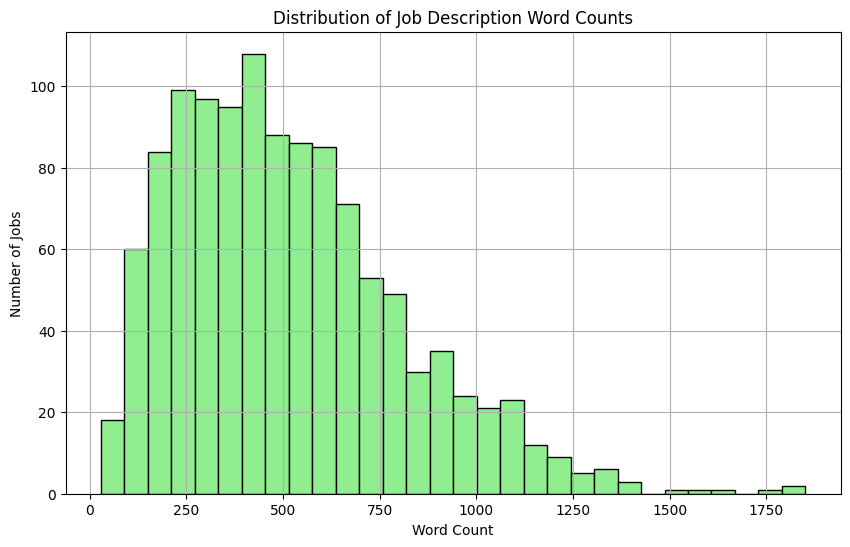

In [65]:
df['word_count'] = df['job_description'].str.split().apply(len)

plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Job Description Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Number of Jobs')
plt.grid(True)
plt.show()


In [66]:
import uuid
import unicodedata
import re
from typing import List, Dict
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer

def clean_unicode(text: str) -> str:
    """
    Cleans up ambiguous or problematic unicode characters and performs additional preprocessing like:
    - Converting to lowercase
    - Removing punctuation
    - Removing extra whitespaces
    - Removing stop words
    - Lemmatizing
    """
    if not isinstance(text, str):
        return ""

    # Normalize and remove ambiguous unicode
    text = unicodedata.normalize('NFKD', text)
    
    # Remove non-printable/control characters
    text = ''.join(c for c in text if c.isprintable())
    
    # Replace smart quotes and dashes with plain ones
    text = text.replace('“', '"').replace('”', '"')
    text = text.replace('‘', "'").replace('’', "'")
    text = text.replace('–', '-').replace('—', '-')
    
    # Remove weird whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Convert to lowercase
    text = text.lower()

    # # Remove punctuation
    # text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    # # Remove stopwords
    # stop_words = set(stopwords.words('english'))
    # text = ' '.join([word for word in text.split() if word not in stop_words])

    # # Lemmatization
    # lemmatizer = WordNetLemmatizer()
    # text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text.strip()

def chunk_text(text: str, chunk_size: int = 400, overlap: int = 50) -> List[str]:
    """
    Splits text into overlapping chunks of specified word size.
    """
    words = text.split()
    if len(words) <= chunk_size:
        return [' '.join(words)]

    chunks = []
    start = 0
    while start < len(words):
        end = start + chunk_size
        chunk = words[start:end]
        chunks.append(' '.join(chunk))
        start += chunk_size - overlap  # Slide window
    return chunks

def chunk_job_descriptions(df: pd.DataFrame, chunk_size: int = 400, overlap: int = 50) -> List[Dict]:
    """
    Processes a DataFrame and returns a list of cleaned, chunked descriptions with metadata.
    """
    all_chunks = []

    for _, row in df.iterrows():
        cleaned_description = clean_unicode(row['job_description'])
        chunks = chunk_text(cleaned_description, chunk_size, overlap)
        for i, chunk in enumerate(chunks):
            chunk_record = {
                'id': str(uuid.uuid4()),
                'job_id': row['job_id'],
                'category': row['category'],
                'job_title': row['job_title'],
                'chunk_index': i,
                'text': chunk
            }
            all_chunks.append(chunk_record)

    return all_chunks


In [67]:
# Assume df is your original dataframe
chunked_data = chunk_job_descriptions(df)

# Convert to DataFrame for preview or export
chunked_df = pd.DataFrame(chunked_data)

# Optional: Save to CSV/JSON for future use
chunked_df.to_csv(str(Path(os.getcwd()).parent.parent / 'data' /"chunked_jobs.csv"), index=False)
